In [1]:
%matplotlib inline
%precision 16
from __future__ import print_function
from six.moves import range
import numpy
import matplotlib.pyplot as plt

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel $\rightarrow$ Restart) and then run all cells (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name and collaborators below:

# HW 6: Hyperbolic Problems

## Question 1 - The Lax-Wendroff & Upwind Methods

Let's consider the advection equation

$$
    u_t + a u_x = 0 ~~~~\mbox{on }[0,L]
$$

with $a,L \in \mathbb R$, and periodic boundary conditions.

**(a)** [10] Implement the Upwind method to solve the advection equation.  Choose $\Delta t$ in a way that you reach the final time $t_f$ to machine accuracy (the resulting time, not the solution).  Also make sure to consider advection velocities that are both positive and negative.

In [2]:
import math

def solve_advection_UPW(a, m, L, t_0, t_final, U_0):
    """Solve the advection equation on a periodic domain using the upwind method
    
    :Input:
     - *a* (float) Advection speed
     - *m* (int) Number of points use to discretize the domain.  Note that
       the total number of points is *m+1*.
     - *L* (float) Length of half of the domain
     - *t_0* (float) Starting time
     - *t_final* (float) Time to integrate to
     - *U_0* (numpy.ndarray) Initial condition at time t_0, should be m+1
     
    :Output:
     - (numpy.ndarray) Solution at time t_final.  Note that this vector should m+1
    """
    
    # YOUR CODE HERE
    delta_x = L / float(m+1)
    
    C = 0.90
    delta_t = C * delta_x / numpy.abs(a)
    t = numpy.arange(t_0, t_final, delta_t)

    time_step = math.ceil((t_final - t_0)/delta_t)
    t = numpy.linspace(t_0, t_final, time_step)
    delta_t = t[1] - t[0]
    
    
    U = numpy.empty((len(t), m+2))
    U[0, :] = U_0
    
    for n in range(len(t)-1):
        if a > 0:
            U[n+1, 0] = U[n, 0] - ((a*delta_t) / delta_x) * (U[n, 0] - U[n, -1]) 
            U[n+1, 1:] = U[n, 1:] - ((a*delta_t) / delta_x) * (U[n, 1:] - U[n, :-1])
        if a < 0:
            U[n+1, 0] = U[n, 0] - ((a*delta_t) / delta_x) * (U[n, 1] - U[n, 0]) 
            U[n+1, 1:-1] = U[n, 1:-1] - ((a*delta_t) / delta_x) * (U[n, 2:] - U[n, 1:-1])
            U[n+1, -1] = U[n, -1] - ((a*delta_t) / delta_x) * (U[n, 0] - U[n, -1])
            
    return U[n+1, :]

Error upwind = 0.09041959826557498
Error upwind = 0.09041959826557501


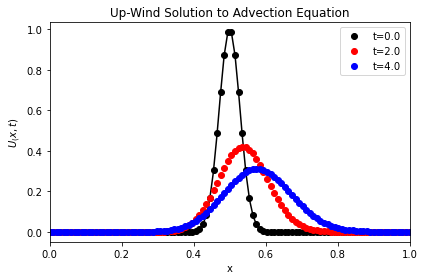

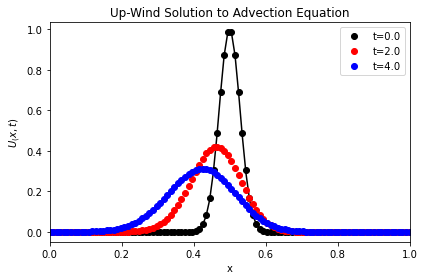

In [3]:
L = 1.0
beta = 600.0
u_true = lambda x, t, a: numpy.exp(- beta * (numpy.mod(x - a * t, L) - 0.5)**2)

# Discretization and output times
m = 100
x = numpy.linspace(0.0, L, m + 2)
x_fine = numpy.linspace(0.0, L, 100)
delta_x = L / float(m + 1)
output_times = (0.0, 2.0, 4.0)

for a in [-2.0, 2.0]:
    # Solve
    U = numpy.empty((len(output_times), m + 2))
    U[0, :] = u_true(x, 0.0, a)
    for (n, t) in enumerate(output_times[1:]):
        U[n + 1, :] = solve_advection_UPW(a, m, L, output_times[n], t, U[n,:])

    error = numpy.linalg.norm(delta_x * (U[-1, :] - u_true(x, output_times[-1], a)), ord=1)
    print("Error upwind = %s" % error)

    # Plot some of the results
    colors = ['k', 'r', 'b', 'g', 'c', 'y']
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x_fine, u_true(x_fine, t, a), 'k-')
    for (n, t) in enumerate(output_times):
        axes.plot(x, U[n, :], "o%s" % colors[n], label='t=%s' % numpy.round(t, 4))
        axes.set_xlabel("x")
        axes.set_ylabel("$U_(x,t)$")
        axes.set_title("Up-Wind Solution to Advection Equation")
        axes.set_xlim([0, L])
        axes.legend()
    plt.tight_layout()
plt.show()

**(b)** [10] Implement the Lax-Wendroff to solve the advection equation with the same requirements as part (a).  Note that the number of grid points in the test is twice that of the above.

In [4]:
def solve_advection_LW(a, m, L, t_0, t_final, U_0):
    """Solve the advection equation on a periodic domain using the Lax-Wendroff method
    
    :Input:
     - *a* (float) Advection speed
     - *m* (int) Number of points use to discretize the domain.  Note that
       the total number of points is *m+1*.
     - *L* (float) Length of half of the domain
     - *t_0* (float) Starting time
     - *t_final* (float) Time to integrate to
     - *U_0* (numpy.ndarray) Initial condition at time t_0, should be m+1
     
    :Output:
     - (numpy.ndarray) Solution at time t_final.  Note that this vector should m+1
    """
    
    # YOUR CODE HERE
    delta_x = L / float(m+1)
    
    # generate time mesh
    C = 0.95
    delta_t = C * delta_x / numpy.abs(a)
    t = numpy.arange(t_0, t_final, delta_t)
    
    # time step correction
    time_step = math.ceil((t_final - t_0)/delta_t)
    t = numpy.linspace(t_0, t_final, time_step)
    delta_t = t[1] - t[0]
 
    U = numpy.empty((len(t), m+2))
    U[0, :] = U_0
    
    # binding parameters for ease of debugging
    
    for n in range(len(t)-1):
        U[n+1, 0] = U[n, 0] - (a*delta_t) / (2.0 * delta_x) * (U[n, 1] - U[n, -1]) \
                            + (a*delta_t)**2 / (2.0 * delta_x**2) * (U[n, 1] - 2.0 * U[n, 0] + U[n, -1])
        
        U[n+1, 1:-1] = U[n, 1:-1] - (a*delta_t) / (2.0 * delta_x) * (U[n, 2:] - U[n, :-2]) \
                                  + (a*delta_t)**2 / (2.0 * delta_x**2) * (U[n, 2:] - 2.0 * U[n,1:-1] + U[n,:-2])
        
        U[n+1, -1] = U[n,-1] - (a*delta_t) / (2.0 * delta_x) * (U[n,0] - U[n,-2]) \
                             + (a*delta_t)**2 / (2.0 * delta_x**2) * (U[n,0] - 2.0 * U[n,-1] + U[n,-2]) 

    return U[n+1, :]

Error LW = 0.07767406242341907
Error LW = 0.07767406242341905


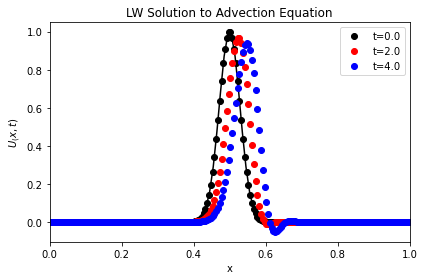

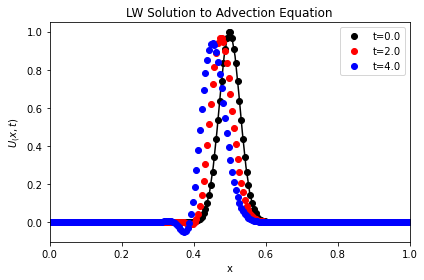

In [5]:
L = 1.0
beta = 600.0
u_true = lambda x, t, a: numpy.exp(- beta * (numpy.mod(x - a * t, L) - 0.5)**2)

# Discretization and output times
m = 200
x = numpy.linspace(0.0, L, m + 2)
x_fine = numpy.linspace(0.0, L, 100)
delta_x = L / float(m + 1)
output_times = (0.0, 2.0, 4.0)

for a in [-2.0, 2.0]:
    # Solve
    U = numpy.empty((len(output_times), m + 2))
    U[0, :] = u_true(x, 0.0, a)
    for (n, t) in enumerate(output_times[1:]):
        U[n + 1, :] = solve_advection_LW(a, m, L, output_times[n], t, U[n,:])

    error = numpy.linalg.norm(delta_x * (U[-1, :] - u_true(x, output_times[-1], a)), ord=1)
    print("Error LW = %s" % error)

    # Plot some of the results
    colors = ['k', 'r', 'b', 'g', 'c', 'y']
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x_fine, u_true(x_fine, t, a), 'k-')
    for (n, t) in enumerate(output_times):
        axes.plot(x, U[n, :], "o%s" % colors[n], label='t=%s' % numpy.round(t, 4))
        axes.set_xlabel("x")
        axes.set_ylabel("$U_(x,t)$")
        axes.set_title("LW Solution to Advection Equation")
        axes.set_xlim([0, L])
        axes.legend()
    plt.tight_layout()
plt.show()

**(c)** [5] Set the final time $t_{final} = 0.1$ and show that the Lax-Wendroff method is second order accurate and the Upwind method first order accurate.

In [6]:
# YOUR CODE HERE
#raise NotImplementedError()

**(d)** [5] What happens to the convergence of both methods if the initial condition is a step discontinuity?  Why might this be?

In [7]:
# YOUR CODE HERE
#raise NotImplementedError()

### Solution:

Neither method will converge for the 1st or 2nd order since the discontinuities will make the error start off very high.

## Question 2 - Modified Equations

**(a)** [10] Show that the modified equation for the _Lax-Wendroff_ method is indeed

$$
    v_t + a v_x = -\frac{1}{6} a \Delta x^2 \left( 1 - \left(\frac{a \Delta t}{\Delta x}\right)^2 \right) v_{xxx}.
$$

## Solution:

Lax-Wendroff is:

$$
     U^{n+1}_j = U^n_j - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1})  + \frac{a^2 \Delta t^2}{2 \Delta x^2} (U^n_{j+1} - 2 U^n_{j} + U^n_{j-1})
$$

Assume that we have a function $v(x,t)$ and an associated PDE. Replace $U$ with a continouous $v$ to get:

$$
v(x,t+\Delta t) = v(x,t) - \frac{a\Delta t}{2\Delta x}\Bigg(v(x+\Delta x,t) - v(x-\Delta x,t)\Bigg)
+ \frac{a^2 \Delta t^2}{2 \Delta x^2}\Bigg(v(x+\Delta x, t) - 2v(x,t) + v(x-\Delta x,t)\Bigg)
$$

Using Taylor Series:

$$
\left(v + v_t \Delta t + \frac{\Delta t^2}{2} v_{tt} + \frac{\Delta t^3}{6} v_{ttt} + \cdots \right)
-v + \frac{a\Delta t}{2\Delta x}\left(v + v_x \Delta x + \frac{\Delta x^2}{2} v_{xx} + \frac{\Delta x^3}{6} v_{xxx}
- v + v_x \Delta x - \frac{\Delta x^2}{2} v_{xx} + \frac{\Delta x^3}{6} v_{xxx} + \cdots \right)
$$
$$
-\frac{a^2 \Delta t^2}{2 \Delta x^2}\left(v + v_x \Delta x + \frac{\Delta x^2}{2} v_{xx} + \frac{\Delta x^3}{6} v_{xxx}
- 2v + v - v_x \Delta x + \frac{\Delta x^2}{2} v_{xx} - \frac{\Delta x^3}{6} v_{xxx} + \cdots \right) = 0
$$

Simplifying:
$$
\left(v_t \Delta t + \frac{\Delta t^2}{2} v_{tt} + \frac{\Delta t^3}{6} v_{ttt} + \cdots \right)
+\frac{a\Delta t}{2\Delta x}\left(2v_x\Delta x + \frac{2\Delta x^3}{6}v_{xxx} + \cdots \right)
-\frac{a^2 \Delta t^2}{2\Delta x^2}\left(\frac{\Delta x^2}{2}v_{xx} + \frac{2\Delta x^3}{6}v_{xxx} + \cdots \right) = 0
$$

And:

$$
\left(v_t \Delta t + \frac{\Delta t^2}{2} v_{tt} + \frac{\Delta t^3}{6} v_{ttt} + \cdots \right)
+a\Delta t\left(v_x + \frac{\Delta x^2}{6}v_{xxx} + \cdots\right) 
-a^2\Delta t^2\left(\frac{v_{xx}}{4} + \frac{\Delta x v_{xxx}}{6} + \cdots \right) = 0
$$

Rearranging and grouping:

$$
v_t\Delta t + av_x\Delta t + \frac{1}{2}\left(\Delta t^2v_{tt} - \frac{a^2\Delta t^2v_{xx}}{2} + \cdots \right)
= -\frac{1}{6}\left(\Delta t^3v_{ttt} + a\Delta x^2\Delta tv_{xxx} - \Delta xa^2\Delta t^2v_{xxx} + \cdots \right)
$$

Cancelling out $v_{tt}$,$v_{ttt}$ and $v_{xx}$ terms as they're handled by the discretization:

$$
v_t\Delta t + av_x\Delta t
= -\frac{1}{6}\left(a\Delta x^2\Delta tv_{xxx} - \Delta xa^2\Delta t^2v_{xxx} + \cdots \right)
$$
Then:

$$
v_t + av_x
= -\frac{1}{6}\left(a\Delta x^2v_{xxx} - \Delta xa^2\Delta tv_{xxx} + \cdots \right)
$$

Then:

$$
v_t + av_x = v_{xxx}\left(-\frac{a\Delta x^2}{6} + \frac{\Delta xa^2\Delta t}{6}\right)
$$

From here we can reach the desired result of the modified equation.

**(b)** [10] Determine the modified equation on which the discretization

$$
    U_j^{n+1} = U_j^n - \frac{a \Delta t}{2 \Delta x}\left(U_j^n - U_{j-1}^n + U_j^{n+1} - U_{j-1}^{n+1} \right)
$$

is second-order accurate. Comment on whether the method's error is dominantly dispersive or dissipative.

## Solution:

Similar to previous part we get:

$$
v(x,t+\Delta t) = v(x,t) - \frac{a\Delta t}{2\Delta x}\left(v(x,t) - v(x-\Delta x,t) + v(x,t + \Delta t) - v(x - \Delta x, t + \Delta t)\right)
$$

Taylor Series:

$$
\left(v + v_t \Delta t + \frac{\Delta t^2}{2} v_{tt} + \frac{\Delta t^3}{6} v_{ttt} + \cdots \right) - v
+ \frac{a\Delta t}{2\Delta x}
\left(v - v + v_x \Delta x - \frac{\Delta x^2}{2} v_{xx} + \frac{\Delta x^3}{6} v_{xxx} + v + v_t \Delta t + \frac{\Delta t^2}{2} v_{tt} + \frac{\Delta t^3}{6} v_{ttt}
-v + \Delta x v_x - \Delta t v_t - \frac{\Delta x^2}{2}v_{xx} - \frac{\Delta t^2}{2}v_{tt} + \frac{\Delta x^3}{6}v_{xxx} - \frac{\Delta t^3}{6}v_{ttt} + \cdots\right)
= 0
$$

Then:

$$
\left(v_t \Delta t + \frac{\Delta t^2}{2} v_{tt} + \frac{\Delta t^3}{6} v_{ttt} + \cdots \right)
+ \frac{a\Delta t}{2\Delta x}\left(2\Delta x v_x - \Delta x^2 v_{xx} + \frac{\Delta x^3}{2}v_{xxx} + \cdots \right) = 0
$$

Second order derivatives are taken care of by the discretization:

$$
v_t + \frac{\Delta t^2}{6}v_{ttt} + av_x - \frac{a\Delta x^2}{4}v_{xxx} = 0
$$

So our modified equation is:

$$
v_t + av_x = \frac{a\Delta x^2}{4}v_{xxx} - \frac{\Delta t^2}{6}v_{ttt}
$$

## Question 3 - Burger's Equation

Consider the non-linear and hyperbolic _Burger's equation_ 

$$
    u_t + uu_x = 0, ~~~~ \mbox{on } [0,L]
$$

with initial condition $u(x,0) = x$.

**(a)** [10] Do you expect that a forward in time, centered in space (FTCS) method would capture or represent the characteristics of this equation? To which extent do you expect a FTCS numerical method to yield good results?  Backup your conclusions with analysis (for instance solve the equation).

## Solution

We get the systems:

$$
\frac{dx}{dt}=u, \; \frac{du}{dt}=0
$$

From there we get the characteristics:

$$
u = c_1
$$
$$
x = ut + c_2 \implies c_2 = x - ut
$$

Then:

$$
u = c_1(x - ut)
$$

Initial condition we need:

$$
c_1(x - u(x,0) \cdot 0) = x \implies c_1 = 1
$$

Therefore:
$$
u(x,t)=\frac{x}{1+t}
$$

Discretization:

$$
\frac{U_j^{n+1}-U_j^{n}}{\Delta t} =  u(\frac{U_{j+1}^{n}-U_{j-1}^{n}}{2 \Delta x})
$$

This scheme is explicit, and there might be a problem with discretization since we have taken an Euler type time-step.

**(b)** [20] Derive a modification of the _Upwind_ method that takes into account the non-constant speed, implement the new method and use it to solve the equation with initial condition

$$
    u(x,0) = x,
$$

with final time $t_{final} = 1.0$.  In this case consider a domain with length $L$ s.t. $x \in [0, L]$ with outflow boundary conditions.

YOUR ANSWER HERE

In [8]:
import math

def solve_burgers_UPW(m, L, t_0, t_final, U_0):
    """Solve Burger's equation using an upwind approach
    
    :Input:
     - *m* (int) Number of points to use to discretize space.
     - *L* (float) Length of domain s.t. x \in [0, L]
     - *t_0* (float) Initial time, u(x, t_0) = U_0
     - *t_final* (float) Final integration time to return
     - *U_0* (ndarray) Initial condition s.t. u(x, t_0) = U_0
     
    :Output:
     - (numpy.ndarray) Approximate solution at time t_final.
    """
    # YOUR CODE HERE
    delta_x = L / float(m + 2)
    cfl = 0.90
    delta_t = cfl * delta_x
    
    time_step = math.ceil((t_final - t_0)/delta_t)
    t = numpy.linspace(t_0, t_final, time_step)
    delta_t = t[1] - t[0]
    
    U = numpy.empty((len(t), m+3))
    U[0, :] = U_0
       
    for n in range(len(t)-1):
        for j in range(U.shape[1]-1):
            a = U[n, j]
            if a > 0:
                U[n+1, j] = U[n, j] - ((a*delta_t) / delta_x) * (U[n, j] - U[n, j-1]) 
            #if a < 0:
            #    U[n+1, j] = U[n, j] - ((a*delta_t) / delta_x) * (U[n, j+1] - U[n, j])
        
    return U[n+1,:]

Error UPW = 0.02561423184100449
Success!


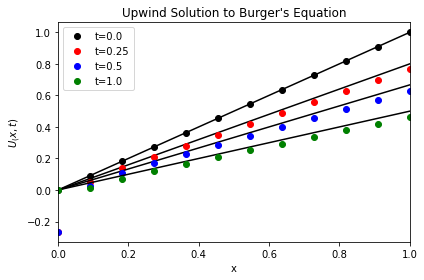

In [9]:
# Equation dependent parameters
L = 1.0
t_0     = 0.0
t_final = 1.0

u_true = lambda x, t: x / (1 + t)

# Discretization and output times
m            = 10
delta_x      = L / float(m + 1)
x            = numpy.linspace(0.0, L+delta_x, m + 3)
x_fine       = numpy.linspace(0.0, L, 100)
output_times = (0.0, 0.25, 0.5, 1.0)

# Solve
U_UPW       = numpy.empty((len(output_times), m + 3))
U_UPW[0, :] = u_true(x, 0.0)

for (n, t) in enumerate(output_times[1:]):
    U_UPW[n + 1, :] = solve_burgers_UPW(m, L, output_times[n], t, U_UPW[n,:])
    
error = numpy.linalg.norm(delta_x * (U_UPW[-1, :-1] - u_true(x[:-1],t_final)), ord=1)
print("Error UPW = %s" % error)
print("Success!")

# Plot some of the results
colors = ['k', 'r', 'b', 'g', 'c']
fig = plt.figure()
axes_BE = fig.add_subplot(1, 1, 1)
for (n, t) in enumerate(output_times):
    axes_BE.plot(x_fine, u_true(x_fine, t), 'k-')
    axes_BE.plot(x[:-1], U_UPW[n, :-1], "o%s" % colors[n], label='t=%s' % numpy.round(t, 4))
    axes_BE.set_xlabel("x")
    axes_BE.set_ylabel("$U_(x,t)$")
    axes_BE.set_title("Upwind Solution to Burger's Equation")
    axes_BE.set_xlim([0, L])
    axes_BE.legend()
    
plt.tight_layout()
plt.show()

**(c)** [5] Plot the convergence of the above method.

<ipython-input-8-b500203313ed>:32: RuntimeWarning: overflow encountered in double_scalars
  U[n+1, j] = U[n, j] - ((a*delta_t) / delta_x) * (U[n, j] - U[n, j-1])
<ipython-input-8-b500203313ed>:32: RuntimeWarning: invalid value encountered in double_scalars
  U[n+1, j] = U[n, j] - ((a*delta_t) / delta_x) * (U[n, j] - U[n, j-1])


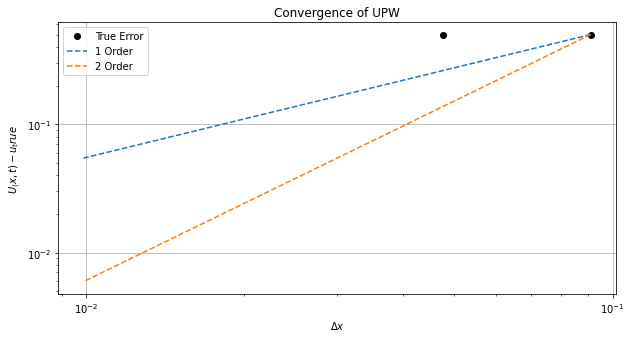

In [10]:
# YOUR CODE HERE
# default parameters. 
 
L = 1
t_0 = 0
t_final = 1
u_true = lambda x, t: x / (1 + t)
ms = numpy.linspace(10,100,10)

# Discretization and output times
errors = [] 
delta_xs = []
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

for m in ms:
    # generate xs and delta x
    m = int(m)
    x = numpy.linspace(0.0, L, m + 3)
    delta_x = L / float(m + 1)
    delta_xs.append(delta_x)

  
    approx_sol = solve_burgers_UPW(m, L, t_0, t_final, u_true(x,0))
    true_sol = u_true(x, t_final)
    diff = numpy.linalg.norm(approx_sol - true_sol)
    errors.append(diff)

plt.figure(figsize=(10,5))
plt.loglog(delta_xs, errors, 'ko', label='True Error')

delta_xs = numpy.array(delta_xs)
errors = numpy.array(errors)

for order in [1,2]:
    plt.loglog(delta_xs, order_C(delta_xs[0], errors[0], order) * delta_xs ** order, '--', label='%s Order' % order)
plt.xlabel("$\Delta x$")
plt.ylabel("$U_(x,t)-u_true$")
plt.title("Convergence of UPW")
plt.grid()
plt.legend() 
plt.show()

**(d)** [15] Write a test for the Burgers equation with the initial condition
$$
    u(x, 0) = \left \{ \begin{aligned}
        1 & & 0 \leq x < L / 2 \\
        0 & & L / 2 \leq x < L
    \end{aligned} \right .
$$
where $L = 1$.  If you asked someone to test their convergence rate using an higher order method (say Beam-Warming) what would you expect to see?

## Solution

In [11]:
def beam_warning(m, L, t_0, t_final, U_0):
    delta_x = L / float(m + 2)
    cfl = 0.90
    delta_t = cfl * delta_x
    
    time_step = math.ceil((t_final - t_0)/delta_t)
    t = numpy.linspace(t_0, t_final, time_step)
    delta_t = t[1] - t[0]
    
    U = numpy.empty((len(t), m+3))
    U[0, :] = U_0
       
    for n in range(len(t)-1):
        for j in range(U.shape[1]-2):
            a = U[n, j]
            if a > 0:
                U[n+1,j] = U[n,j] - ((a*delta_t) / (2.0 * delta_x)) * (3.0 * U[n,j] - 4.0 * U[n,j-1] + U[n,j-2]) \
                + ((a**2 * delta_t**2) / (2.0 * delta_x**2)) * (U[n,j] - 2.0 * U[n,j-1] + U[n,j-2]) 
            if a < 0:
                U[n+1,j] = U[n,j] - ((a*delta_t) / (2.0 * delta_x)) * (-3.0 * U[n,j] - 4.0 * U[n,j+1] - U[n,j+2]) \
               + ((a**2 * delta_t**2) / (2.0 * delta_x**2)) * (U[n,j] - 2.0 * U[n,j+1] + U[n,j+2]) 
        
    return U[n+1,:]

## Testing the Beam Warning Code

Error UPW = 0.02702628354393989
Success!


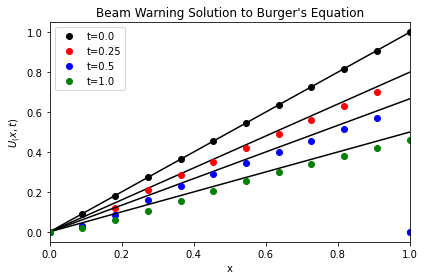

In [12]:
import math

# Equation dependent parameters
L = 1
t_0     = 0.0
t_final = 1

u_true = lambda x, t: x / (1 + t)

# Discretization and output times
m            = 10
delta_x      = L / float(m + 1)
x            = numpy.linspace(0.0, L+delta_x, m + 3)
x_fine       = numpy.linspace(0.0, L, 100)
output_times = (0.0, 0.25, 0.5, 1.0)

# Solve
U_UPW       = numpy.empty((len(output_times), m + 3))
U_UPW[0, :] = u_true(x, 0.0)

for (n, t) in enumerate(output_times[1:]):
    U_UPW[n + 1, :] = beam_warning(m, L, output_times[n], t, U_UPW[n,:])
    
error = numpy.linalg.norm(delta_x * (U_UPW[-1, :-1] - u_true(x[:-1],t_final)), ord=1)
print("Error UPW = %s" % error)
print("Success!")

# Plot some of the results
colors = ['k', 'r', 'b', 'g', 'c']
fig = plt.figure()
axes_BE = fig.add_subplot(1, 1, 1)
for (n, t) in enumerate(output_times):
    axes_BE.plot(x_fine, u_true(x_fine, t), 'k-')
    axes_BE.plot(x[:-1], U_UPW[n, :-1], "o%s" % colors[n], label='t=%s' % numpy.round(t, 4))
    axes_BE.set_xlabel("x")
    axes_BE.set_ylabel("$U_(x,t)$")
    axes_BE.set_title("Beam Warning Solution to Burger's Equation")
    axes_BE.set_xlim([0, L])
    axes_BE.legend()
    
plt.tight_layout()
plt.show()

<ipython-input-11-25bba6f64373>:17: RuntimeWarning: overflow encountered in double_scalars
  U[n+1,j] = U[n,j] - ((a*delta_t) / (2.0 * delta_x)) * (3.0 * U[n,j] - 4.0 * U[n,j-1] + U[n,j-2]) \
<ipython-input-11-25bba6f64373>:18: RuntimeWarning: overflow encountered in double_scalars
  + ((a**2 * delta_t**2) / (2.0 * delta_x**2)) * (U[n,j] - 2.0 * U[n,j-1] + U[n,j-2])
<ipython-input-11-25bba6f64373>:17: RuntimeWarning: invalid value encountered in double_scalars
  U[n+1,j] = U[n,j] - ((a*delta_t) / (2.0 * delta_x)) * (3.0 * U[n,j] - 4.0 * U[n,j-1] + U[n,j-2]) \
<ipython-input-11-25bba6f64373>:20: RuntimeWarning: overflow encountered in double_scalars
  U[n+1,j] = U[n,j] - ((a*delta_t) / (2.0 * delta_x)) * (-3.0 * U[n,j] - 4.0 * U[n,j+1] - U[n,j+2]) \
<ipython-input-11-25bba6f64373>:21: RuntimeWarning: overflow encountered in double_scalars
  + ((a**2 * delta_t**2) / (2.0 * delta_x**2)) * (U[n,j] - 2.0 * U[n,j+1] + U[n,j+2])
<ipython-input-11-25bba6f64373>:20: RuntimeWarning: invalid valu

[0.0909090909090909 0.0476190476190476 0.032258064516129
 0.024390243902439  0.0196078431372549 0.0163934426229508
 0.0140845070422535 0.0123456790123457 0.010989010989011
 0.0099009900990099]
[0.0416586561568038 0.0549051437834632 0.0652821336201847
 0.0746746583247117 0.0779032564941191 0.0901200121324558
 0.0969923696749896 0.1034017138411509 0.1094322788645317
 0.1151450370353786]


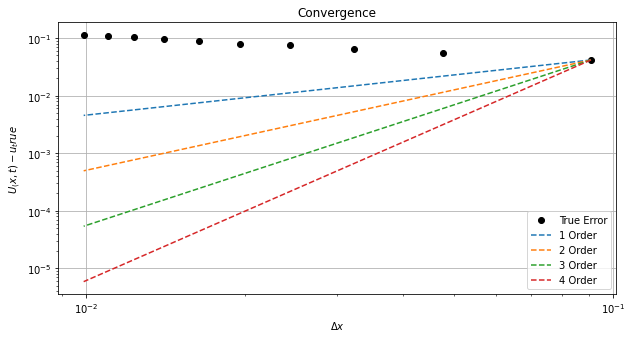

In [13]:
# YOUR CODE HERE
# default parameters. 
L = 1
t_0 = 10
t_final = 50
u_true = lambda x, t: x / (1 + t)
ms = numpy.linspace(10, 100, 10)

errors = [] 
delta_xs = []
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

for m in ms:
    m = int(m)
    x = numpy.linspace(0.0, L, m + 3)
    delta_x = L / float(m + 1)
    delta_xs.append(delta_x)

    #Initial Condition
    init_cond = numpy.zeros(x.shape)
    init_cond[x < L/2] = 1
    init_cond[x >= L/2] = 0

    approx_sol = beam_warning(m, L, t_0, t_final, init_cond)
    true_sol = u_true(x, t_final)
    diff = numpy.linalg.norm(approx_sol - true_sol)
    errors.append(diff)

    
plt.figure(figsize=(10,5))
plt.loglog(delta_xs, errors, 'ko', label='True Error')

delta_xs = numpy.array(delta_xs)
errors = numpy.array(errors)
print(delta_xs)
print(errors)

for order in [1,2,3,4]:
    plt.loglog(delta_xs, order_C(delta_xs[0], errors[0], order) * delta_xs ** order, '--', label='%s Order' % order)
plt.xlabel("$\Delta x$")
plt.ylabel("$U_(x,t)-u_true$")
plt.title("Convergence") 
plt.grid()
plt.legend() 
plt.show() 



We should expect convergence with large errors at the shock point, but I cannot seem to replicate the results. Why might that be?